# Stock Market Portfolio Optimization with Python

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

#define the time period for the data
end_date=date.today().strftime("%Y-%m-%d")
start_date= (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

#list of stock tickers to download (track and performance of the stock)
tickers=['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

data=yf.download(tickers, start=start_date,end=end_date,progress=False)

#reset index to bring date into the columns for the melt functions (transforming a DataFrame in pandas )
data=data.reset_index()

#Melt the dataframe to make it long format where each row is a unique combination of date, tickers and attributes
data_melted=data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

#pivot the melted dataframe to have the attributes(open, high, low,etc)as columns
data_pivoted=data_melted.pivot_table(index=['Date','Ticker'],columns='Attribute', values='value',aggfunc='first')

#reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-07-10  HDFCBANK.NS  1634.135132  1656.449951  1676.750000   
1         2023-07-10      INFY.NS  1304.812012  1329.150024  1341.900024   
2         2023-07-10  RELIANCE.NS  2515.564209  2524.450195  2543.787109   
3         2023-07-10       TCS.NS  3216.648682  3271.949951  3324.750000   
4         2023-07-11  HDFCBANK.NS  1626.193604  1648.400024  1676.000000   

Attribute          Low         Open      Volume  
0          1649.699951  1661.000000  19199221.0  
1          1319.300049  1336.550049   3940315.0  
2          2469.024170  2481.853760  16620008.0  
3          3265.199951  3324.750000   1407431.0  
4          1645.500000  1663.000000  25335213.0  


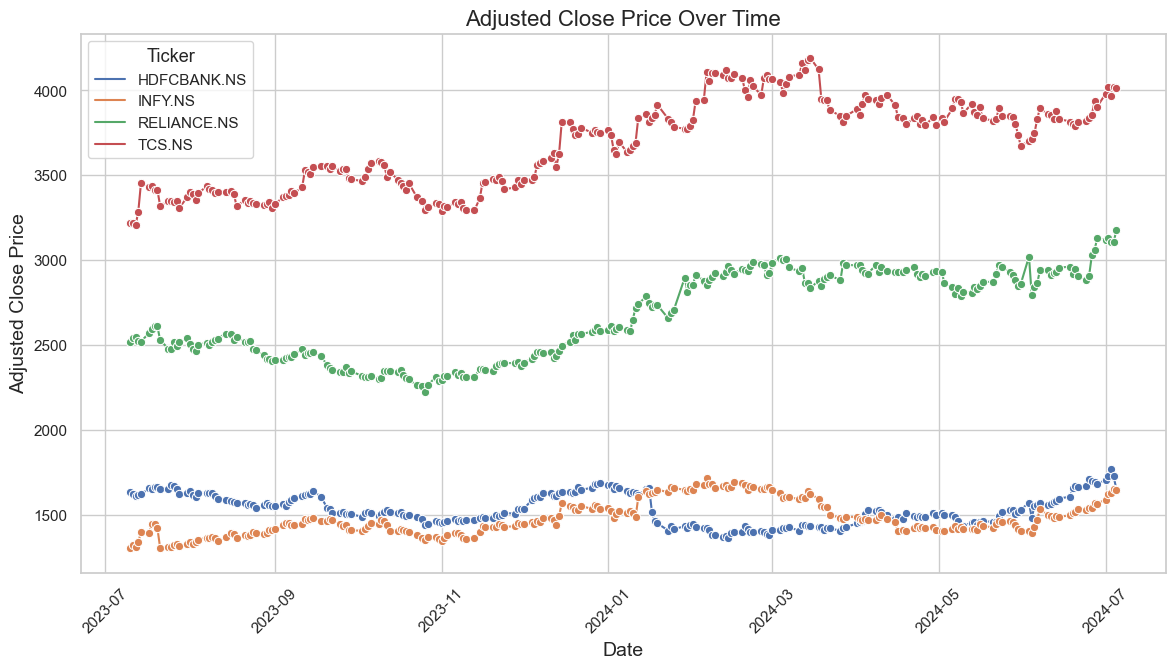

In [4]:
#Now, let’s have a look at the stock market performance of these companies in the stock market over time:
#july 2023 to july 2024
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date']) #Date column in the stock_data

stock_data.set_index('Date', inplace=True) #Date column as the index of the DataFrame
stock_data.reset_index(inplace=True) #Date a column again
plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker',marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)
plt.show()

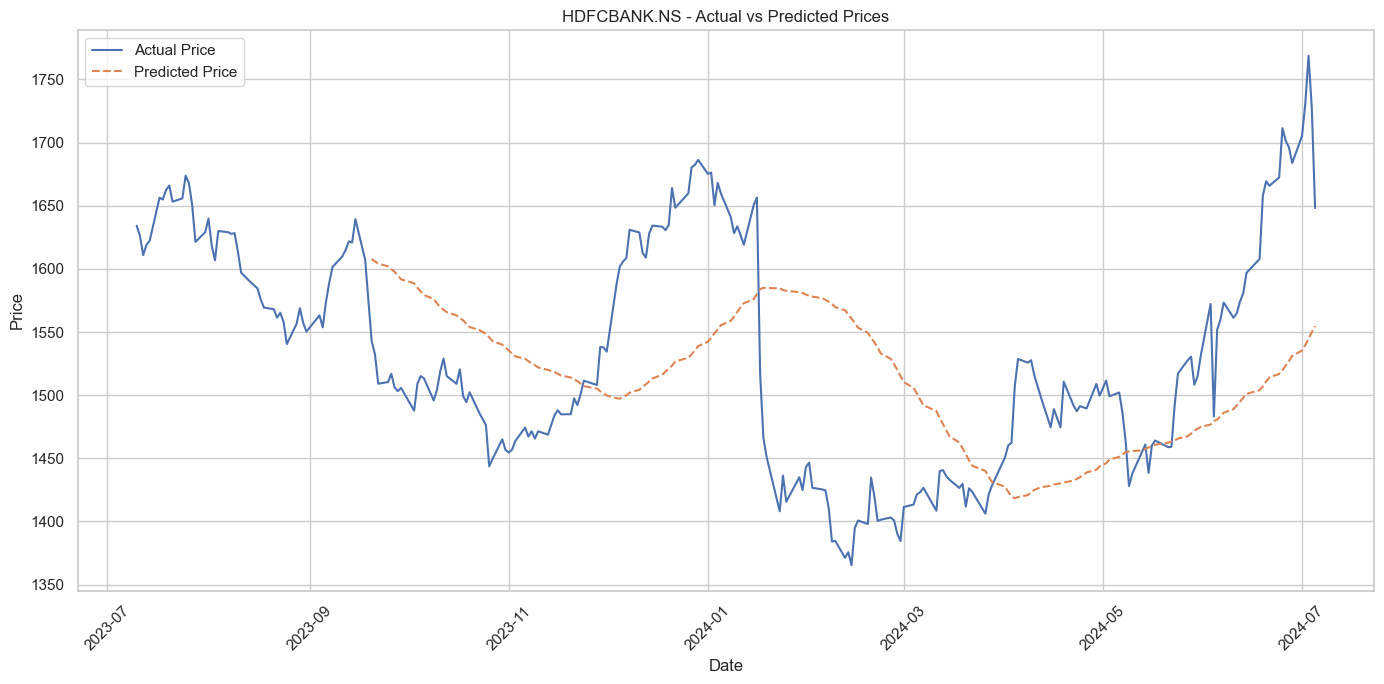

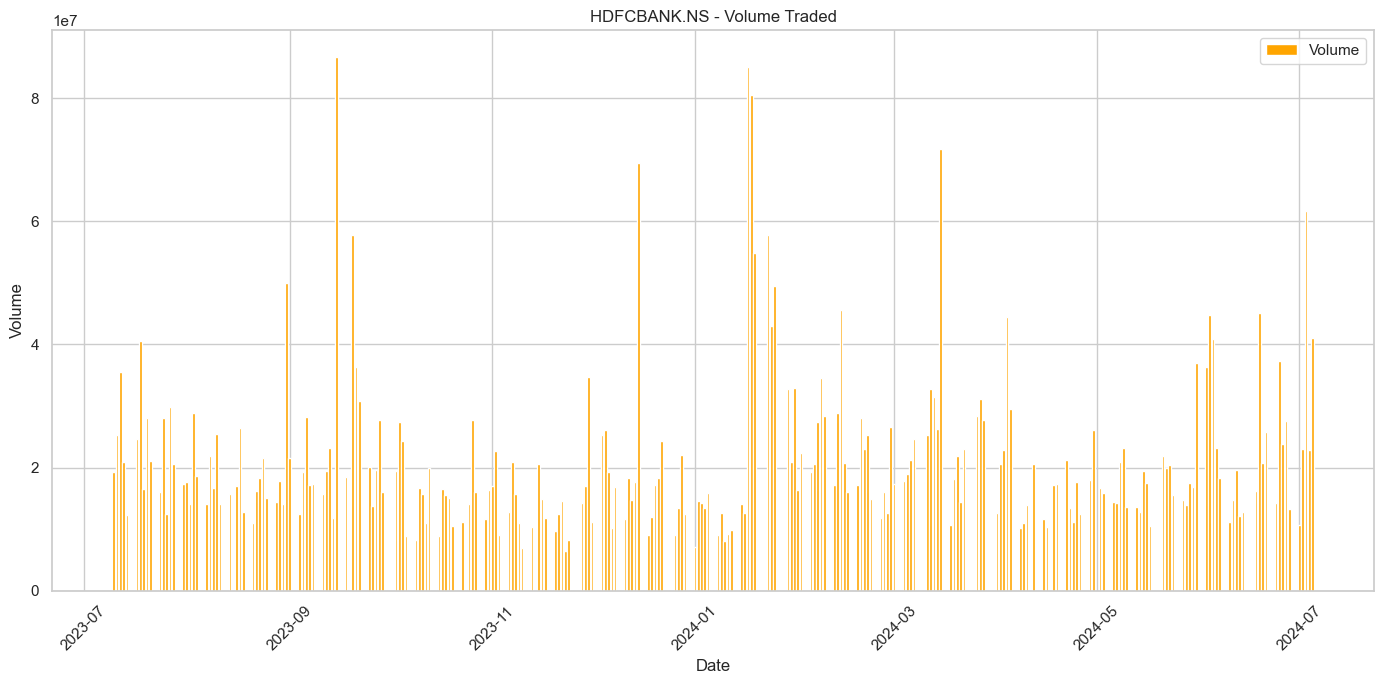

HDFCBANK.NS - RMSE: 103.04


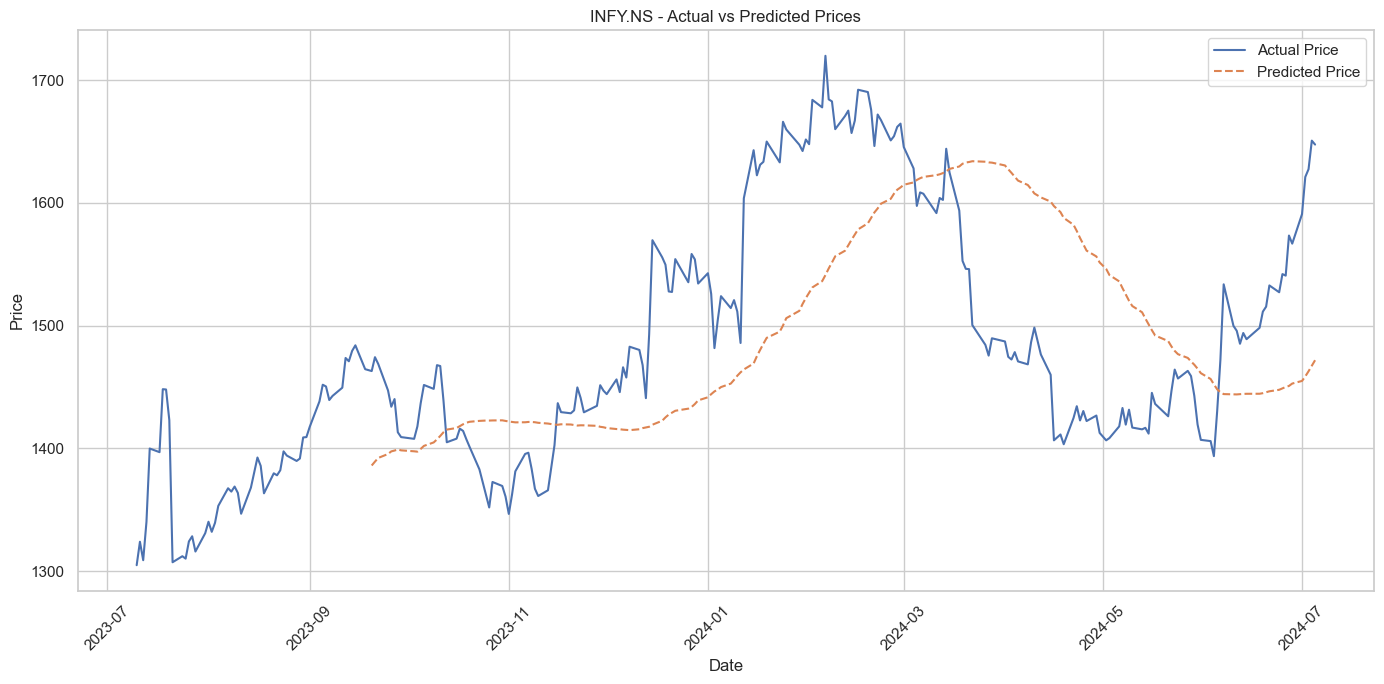

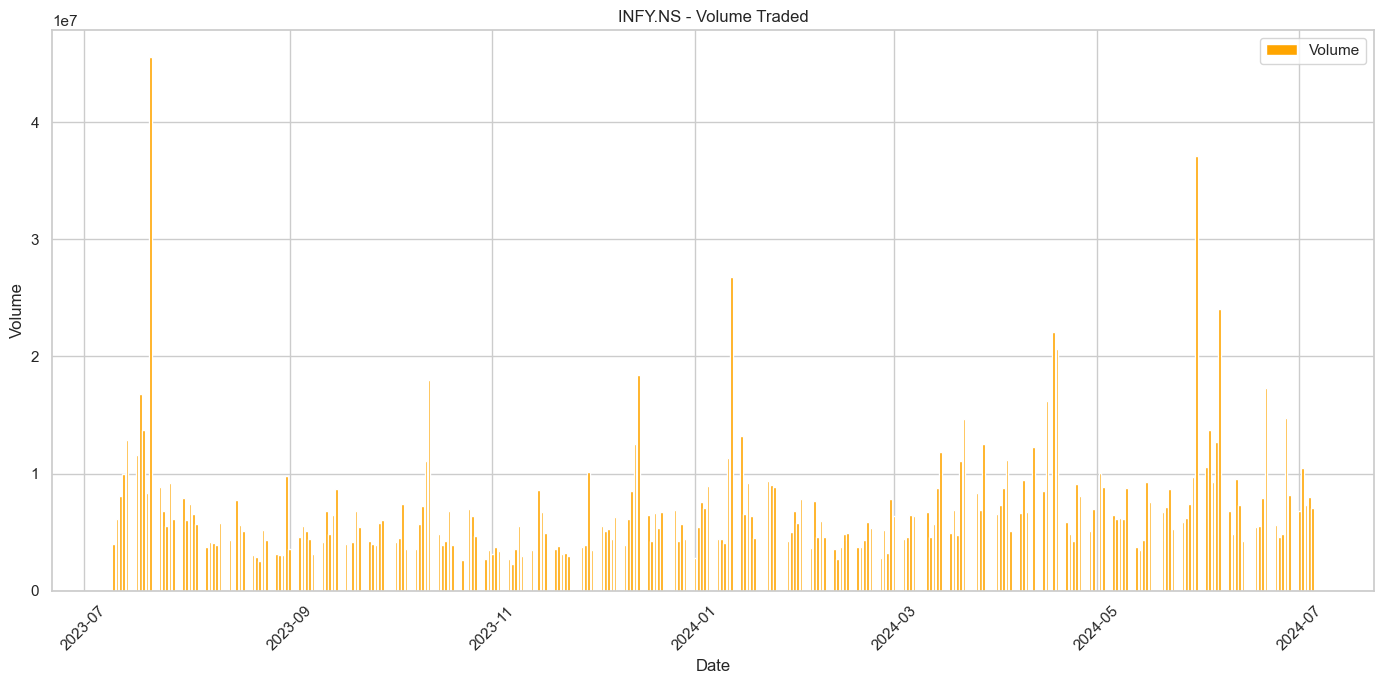

INFY.NS - RMSE: 88.74


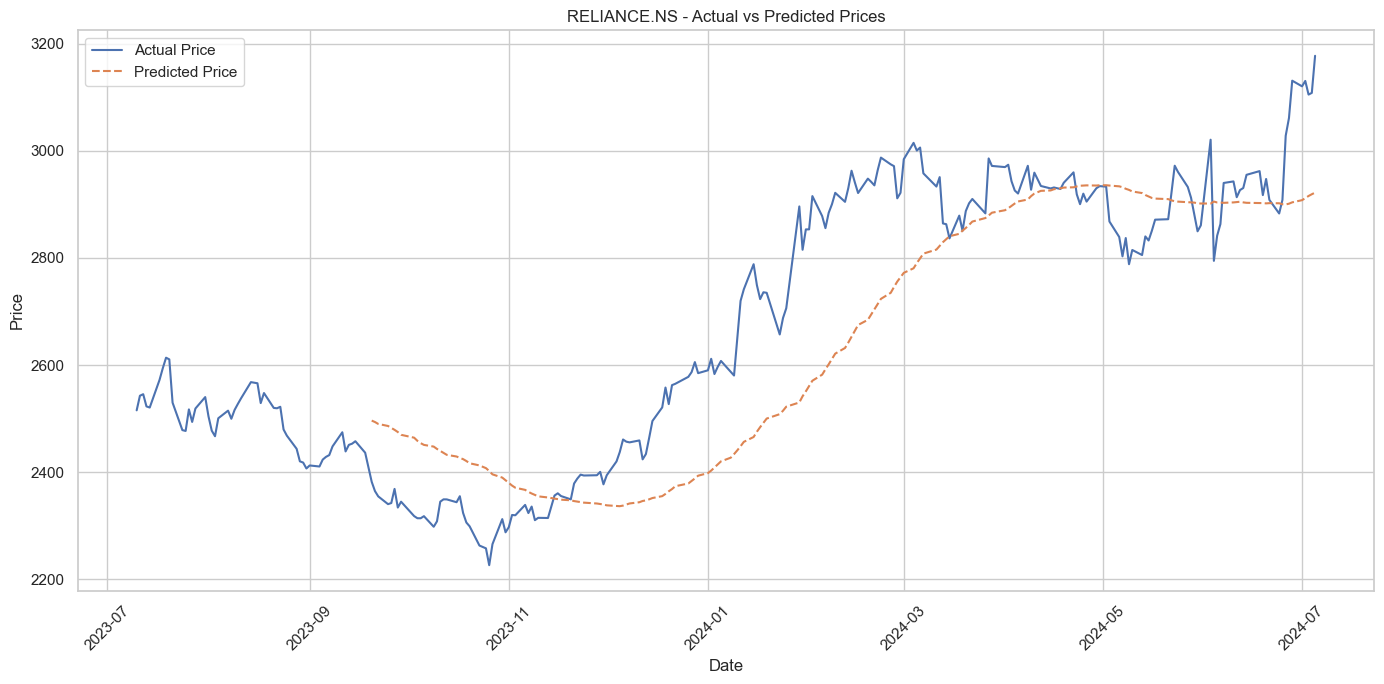

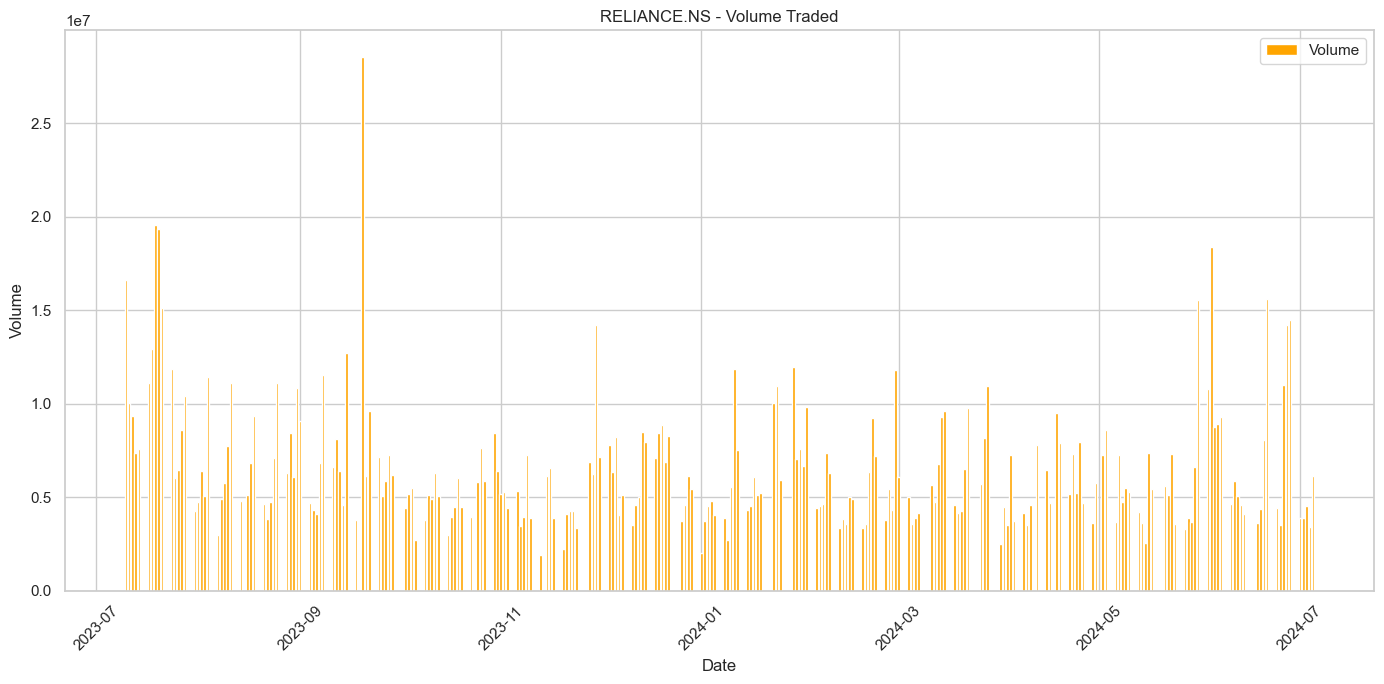

RELIANCE.NS - RMSE: 104.93


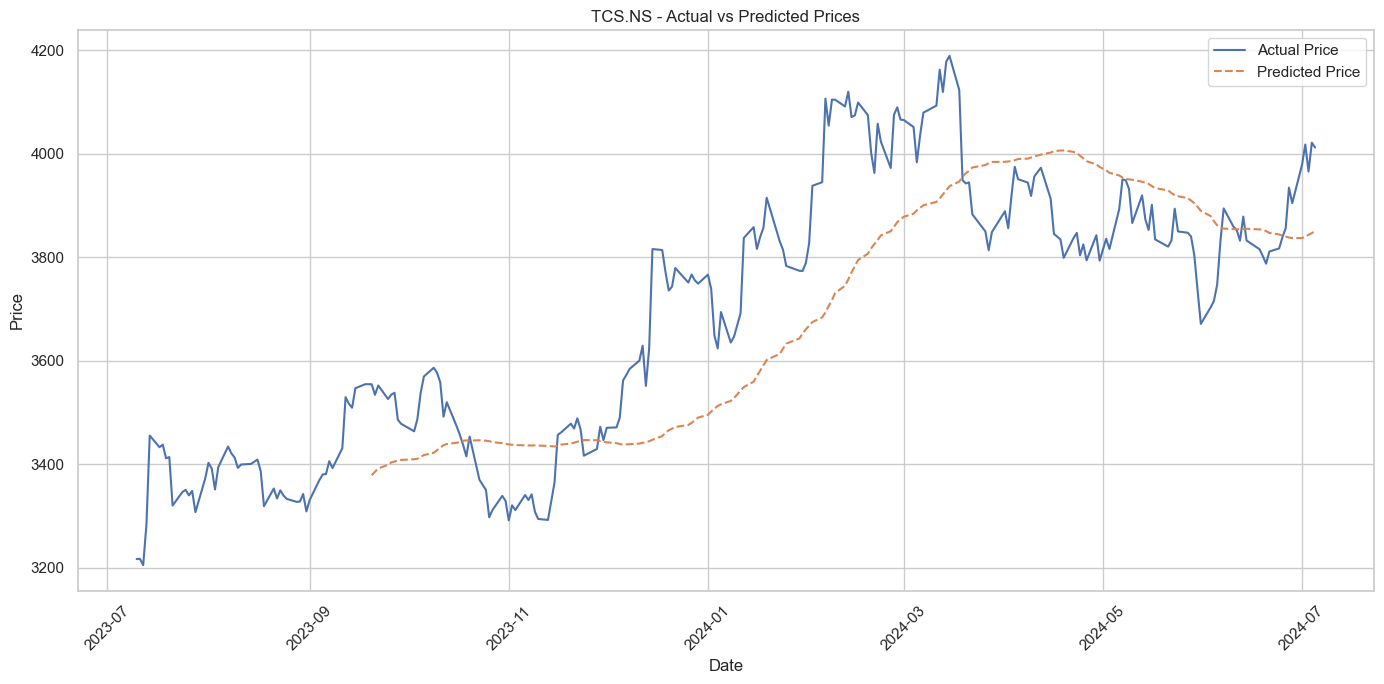

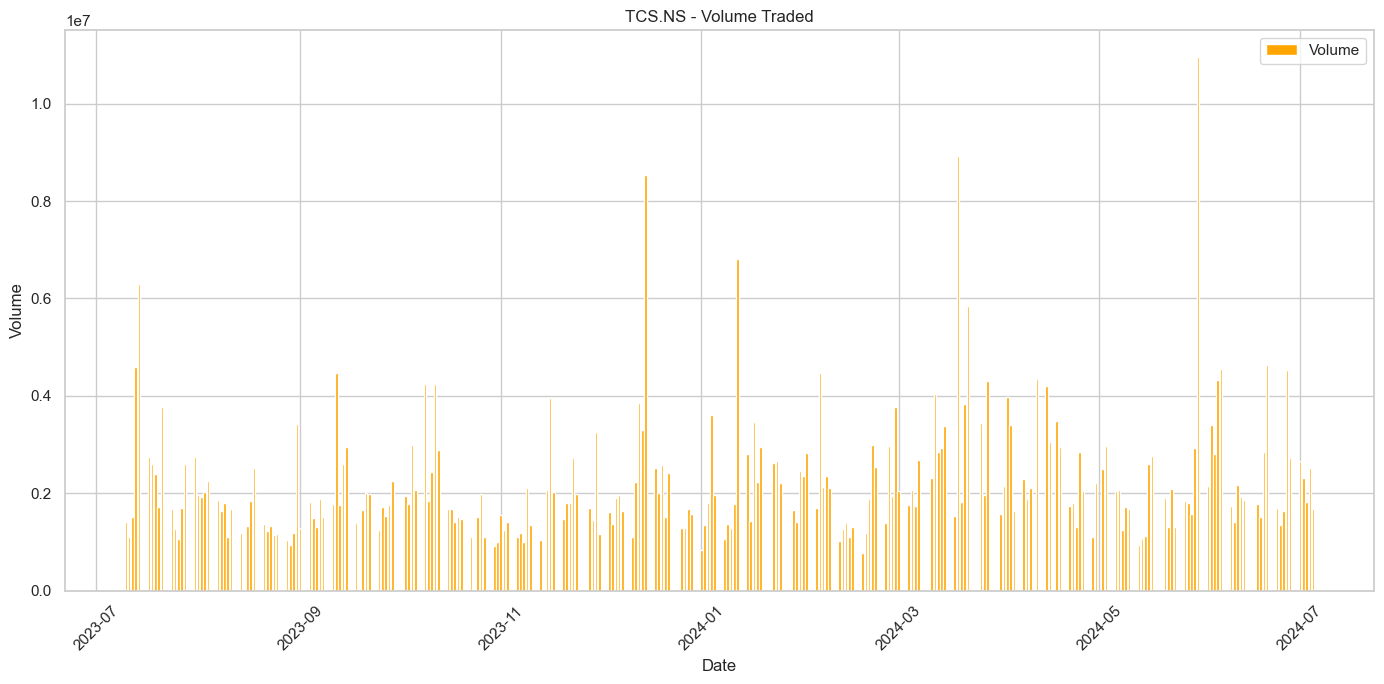

TCS.NS - RMSE: 94.85


In [5]:
#Now, let’s compute the 50-day and 200-day moving averages and plot these along with the Adjusted Close price for each stock:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume stock_data is already loaded and contains the necessary columns

short_window = 50
long_window = 200

# Reset index to bring 'Date' column back
stock_data.reset_index(inplace=True)

# Ensure 'Date' is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()
    
    # Predict the next day's price using the 50-day moving average of the previous day
    ticker_data['Predicted Price'] = ticker_data['50_MA'].shift(1)

    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Actual Price')
    plt.plot(ticker_data.index, ticker_data['Predicted Price'], label='Predicted Price', linestyle='dashed')
    plt.title(f'{ticker} - Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot volume traded
    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy metrics
    ticker_data.dropna(inplace=True)  # Drop NaN values that result from shifting
    mse = ((ticker_data['Adj Close'] - ticker_data['Predicted Price']) ** 2).mean()
    rmse = np.sqrt(mse)
    print(f'{ticker} - RMSE: {rmse:.2f}')


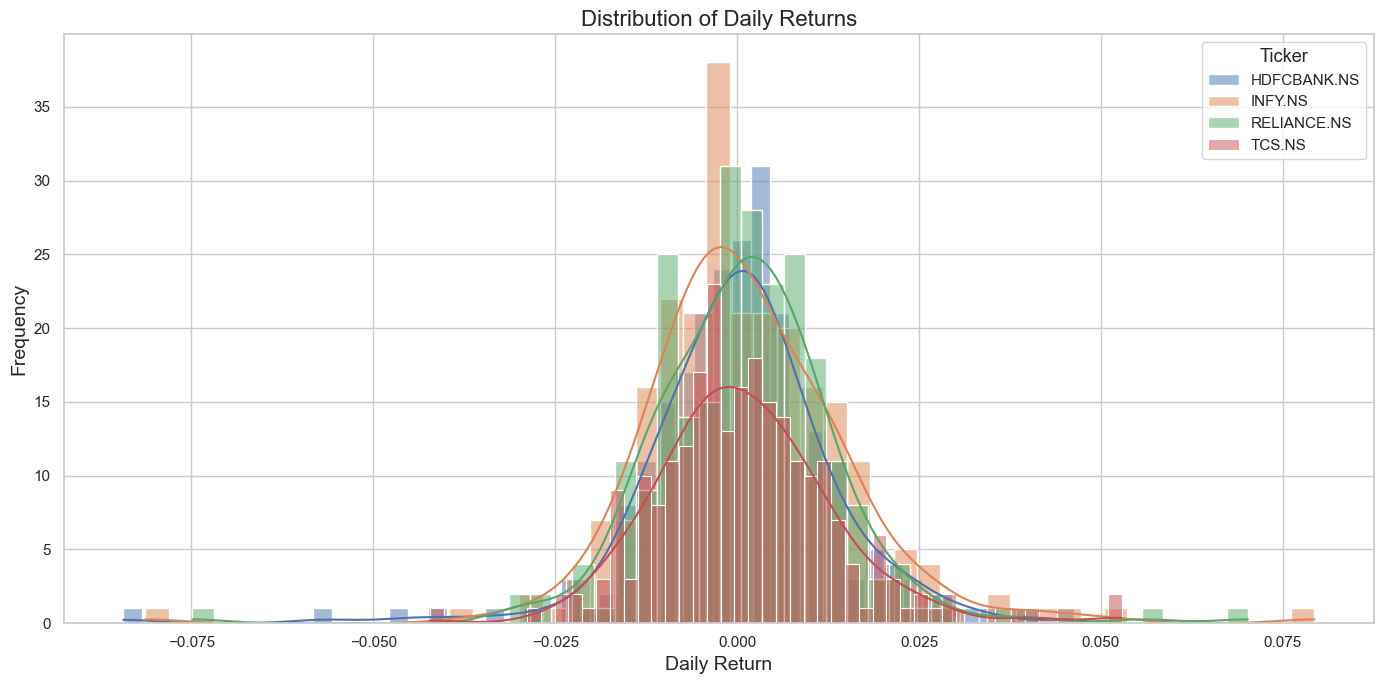

In [7]:
#Now, let’s have a look at the distribution of daily returns of these stocks:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change() #( calculation of daily returns is done separately for each stock)(percentage change which represents the daily return.)

plt.figure(figsize=(14,7))
sns.set(style='whitegrid') #'whitegrid' for a clean background with gridlines.

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker] #Filters the data for the current ticker.
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)
    
plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout() #all elements fit within the figure area without overlapping.
plt.show()


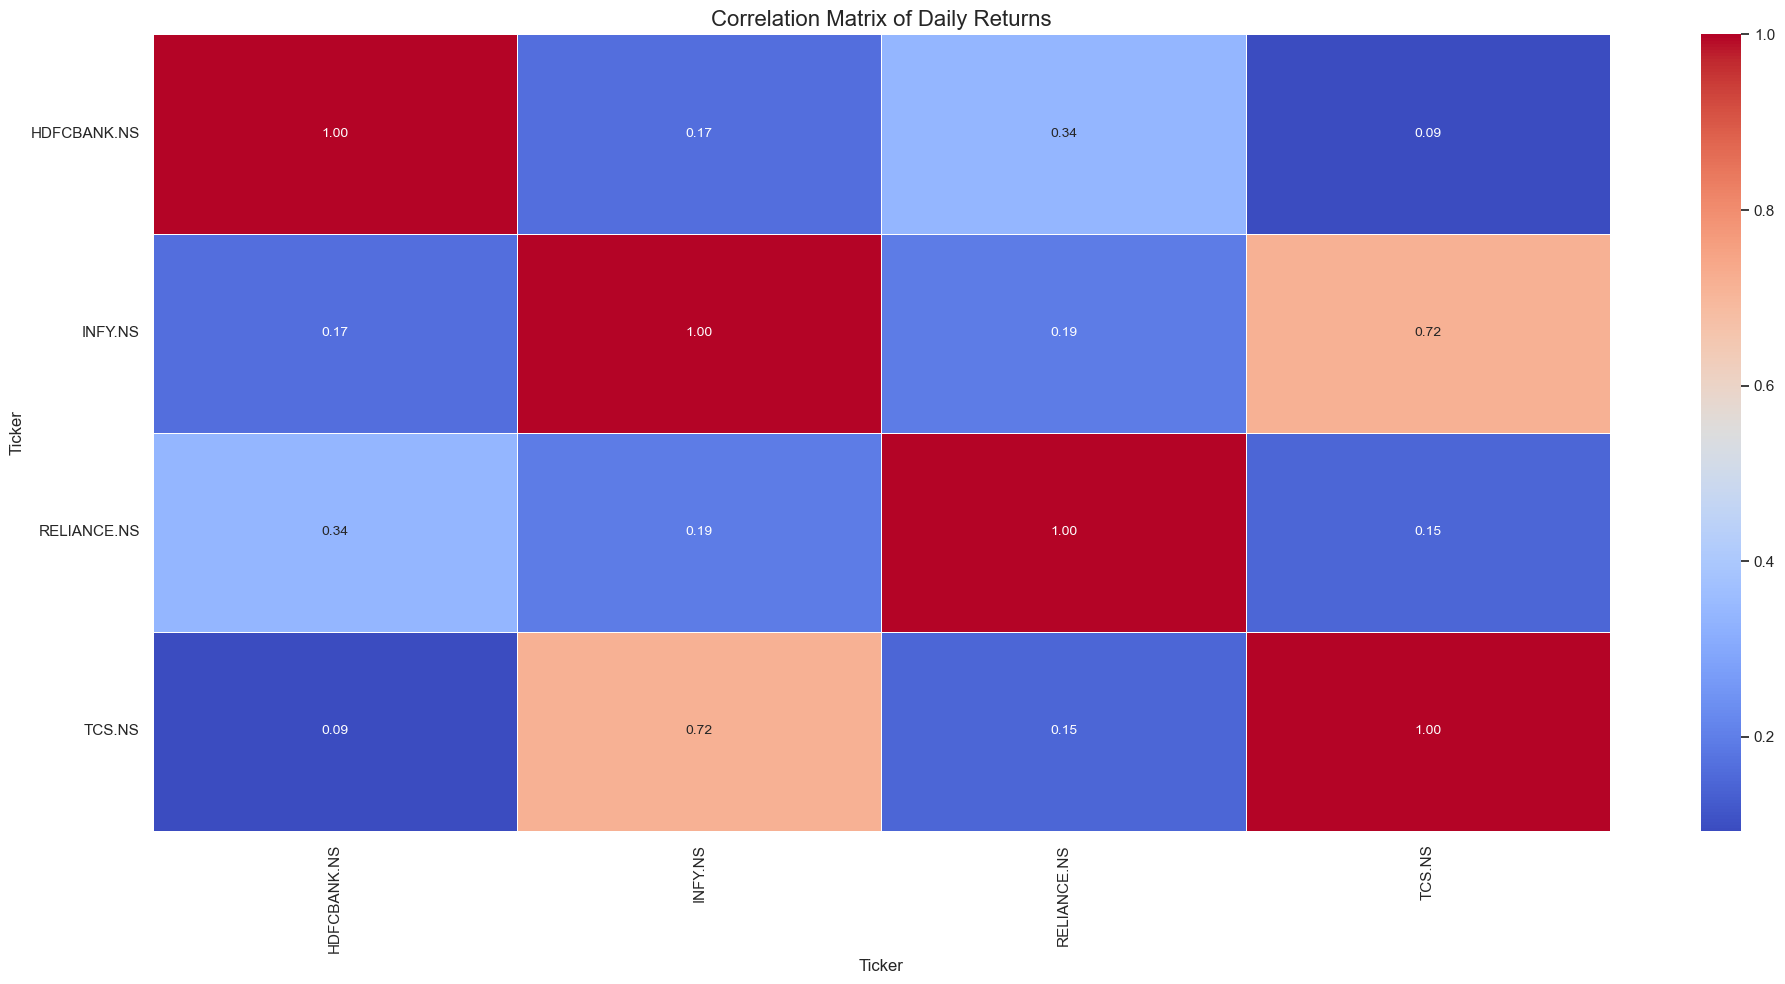

In [8]:
#Now, let’s see if there’s any correlation between all these stocks:
daily_returns = stock_data.pivot_table(index = 'Date', columns = 'Ticker', values = 'Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(20,10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = .5, fmt = '.2f', annot_kws = {"size":10})
plt.title('Correlation Matrix of Daily Returns', fontsize = 16)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

# Portfolio Optimization

In [9]:
#Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:
#1) Calculate the expected returns and volatility for each stock.

import numpy as np
#volatility-how much the stock's returns are expected to fluctuate over a year.
expected_returns = daily_returns.mean() * 252 #annualize the returns (daily returns for each stock)(252 represent as the average no. of trading days in a year)
volatility = daily_returns.std() * np.sqrt(252) #annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns, #annualized expected returns for each stock.
    'Volatility': volatility #annualized volatility for each stock.
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.031697,0.212872
INFY.NS,0.269982,0.233450
RELIANCE.NS,0.265480,0.211266
TCS.NS,0.249487,0.197770


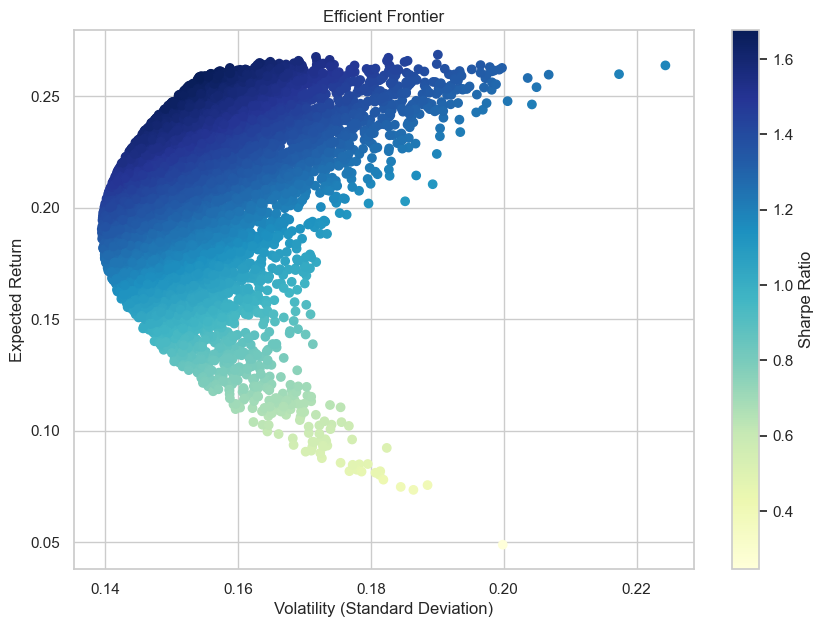

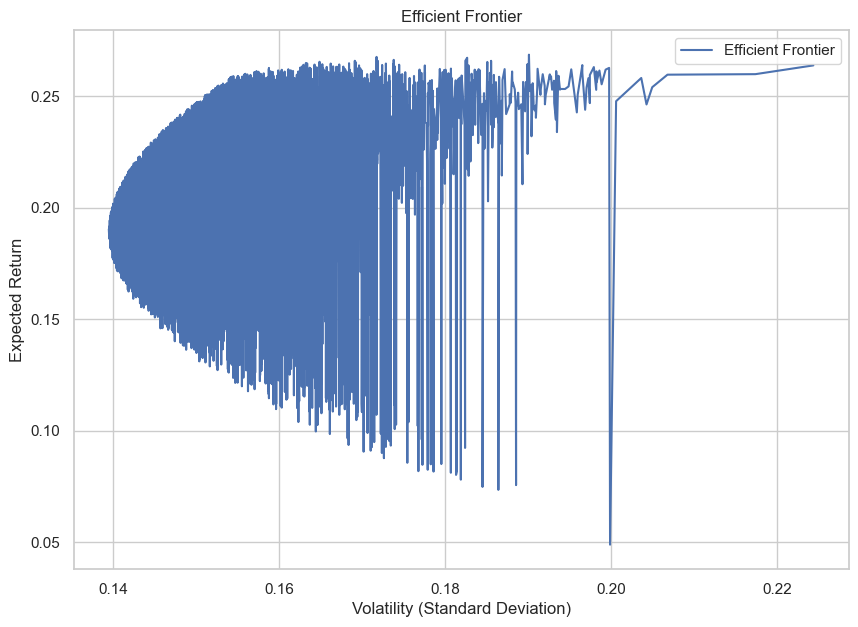

In [12]:
#2) Generate a large number of random portfolio weights.


#function to calculate portfolio performance
def portfolio_perform(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) #portfolio's volatility (standard deviation) using the covariance matrix and the weights
    return portfolio_return, portfolio_volatility 

#no. of portfolio to simulate
num_portfolios = 10000

#arrays to store the results
results = np.zeros((3, num_portfolios))

#annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios): #Loops over the number of portfolios to simulate.
    weights = np.random.random(len(unique_tickers)) #Generates random weights for each stock.
    weights /= np.sum(weights) #Normalizes the weights so that they sum to 1.
    
    portfolio_return, portfolio_volatility = portfolio_perform(weights, expected_returns, cov_matrix) #Calculates the portfolio's expected return and volatility.

    results[0,i] = portfolio_return #Stores the portfolio's return.
    results[1,i] = portfolio_volatility #Stores the portfolio's volatility
    results[2,i] = portfolio_return / portfolio_volatility #Sharpe Ratio(return to risk ratio)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Return': results[0, :],
    'Volatility': results[1, :],
    'Sharpe Ratio': results[2, :]
})

# Sort the DataFrame by Volatility
results_df = results_df.sort_values(by='Volatility')

plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker = 'o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(results_df['Volatility'], results_df['Return'], label='Efficient Frontier')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
#Here’s how to identify the portfolio with the maximum Sharpe ratio:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1,max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.25843412261114806, 0.1541655111662526, 1.6763420083785916)

In [14]:
#Next, let’s identify the weights of the stocks in the portfolio that yield the maximum Sharpe ratio:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_perform(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.216328
1,INFY.NS,0.319639
2,RELIANCE.NS,0.119568
3,TCS.NS,0.344464


In [ ]:
short_window=50
long_window=200

stock_data.set_index('Date', inplace=True)
unique_tickers=stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()
    
    plt.figure(figsize=(14,7))
    plt.plot(ticker_data.index,ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index,ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index,ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.bar(ticker_data.index,ticker_data['Volume'],label='Volume',color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show